# Project: Lane detection (Advanced)
data and guidelines from https://github.com/udacity/CarND-Advanced-Lane-Lines

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

# Camera calibration

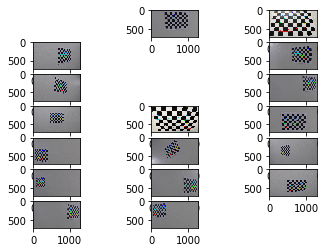

In [9]:
images = glob.glob('camera_cal/calibration*.jpg')

for idx, image in enumerate(images):
    image = cv2.imread(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        cv2.drawChessboardCorners(image, (9, 6), corners, ret)
        plt.subplot(len(images)/3+1, 3, idx+1), plt.imshow(image)

In [3]:
#Pickle the matrices
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
cal_pickle = {}
cal_pickle["mtx"] = mtx
cal_pickle["dist"] = dist
pickle.dump( cal_pickle, open( "camera_cal/calibration_pickle.p", "wb" ) )

In [3]:
import os
os.listdir("test_images/")

['straight_lines1.jpg',
 'test5.jpg',
 'test1.jpg',
 'test6.jpg',
 'test4.jpg',
 'test3.jpg',
 'test2.jpg',
 'straight_lines2.jpg']

# Detection pipeline

In [5]:
# Define all the important functions

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use RGB2GRAY if you read an image with mpimg

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def undistort(img):
    cal_pickle = pickle.load( open( "camera_cal/calibration_pickle.p", "rb" ) )
    mtx = cal_pickle["mtx"]
    dist = cal_pickle["dist"]
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def x_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = grayscale(img)
    # Take only Sobel x 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    #Calculate the absolute value of the x derivative:
    abs_sobelx = np.absolute(sobelx)
    #Convert the absolute value image to 8-bit:
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #Create binary image using thresholding
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sxbinary

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = grayscale(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    gray = grayscale(img)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    binary_output = np.zeros_like(dir_grad)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
   
    return binary_output

def hsv_select(img, thresh_low, thresh_high):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    color_binary = np.zeros((img.shape[0], img.shape[1]))
    color_binary[(hsv[:,:,0] >= thresh_low[0]) & (hsv[:,:,0] <= thresh_high[0]) 
                  & (hsv[:,:,1] >= thresh_low[1])  & (hsv[:,:,1] <= thresh_high[1])  
                  & (hsv[:,:,2] >= thresh_low[2]) & (hsv[:,:,2] <= thresh_high[2])] = 1
    return color_binary 

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    s = hls[:,:,2]
    s_binary = np.zeros_like(s)
    s_binary[(s > thresh[0]) & (s <= thresh[1])] = 1
    return s_binary

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32([[800,510],[1150,700],[270,700],[510,510]])
    dst = np.float32([[650,470],[640,700],[270,700],[270,510]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    
    #inverse 
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #create a warped image
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    unpersp = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, unpersp, Minv

# Function for saving images to an output folder
def create_pathname(infile, ext):
    temp1 = os.path.split(infile)[-1]
    temp2 = os.path.splitext(temp1)[0] + ext
    outfile = os.path.join("output1/", temp2)
    return outfile

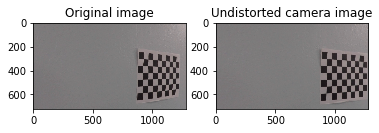

In [6]:
#Distortion corrected camera calibration image
image_orig = 'camera_cal/calibration15.jpg'
img = cv2.imread(image_orig)
undist = undistort(img)

plt.figure(figsize=(1,1))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(img)
a.set_title('Original image')

a=fig.add_subplot(122)
plt.imshow(undist)
a.set_title('Undistorted camera image')

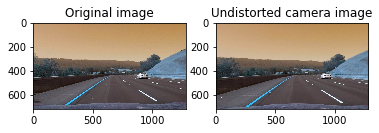

In [7]:
#Distortion corrected testimage
image_orig = 'test_images/test3.jpg'
img = cv2.imread(image_orig)
undist = undistort(img)

plt.figure(figsize=(1,1))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(img)
a.set_title('Original image')

a=fig.add_subplot(122)
plt.imshow(undist)
a.set_title('Undistorted camera image')

In [8]:
# Define a function for creating lane lines
def lane_detector(image, video_mode = False):
    #read image
    if video_mode == False:
        image = cv2.imread(image)
    
    # Undistort image
    undist = undistort(image)
    #print(undist.shape)
    
    # Define a kernel size and apply Gaussian smoothing
    apply_blur = True
    if apply_blur:
        kernel_size = 5
        undist = gaussian_blur(undist, kernel_size)

    # Define parameters for gradient thresholding
    sxbinary = x_thresh(undist, sobel_kernel=3, thresh = (22,100))
    mag_binary = mag_thresh(undist, sobel_kernel=3, thresh=(40, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=15, thresh=(0.7, 1.3))
    
    # Define parameters for color thresholding
    s_binary = hls_select(undist, thresh=(90, 255))
    
    #You can combine various thresholding operations
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary1 = np.zeros_like(sxbinary)
    combined_binary1[(s_binary == 1) | (sxbinary == 1)] = 1
    
    combined_binary2 = np.zeros_like(sxbinary)
    combined_binary2[(s_binary == 1) | (sxbinary == 1)| (mag_binary == 1)] = 1
    
    # Apply perspective transform
    # Define points
    warped_im, _ , Minv = warp(combined_binary1)
    
    return undist, sxbinary, s_binary, combined_binary1, warped_im, Minv

# Test on images

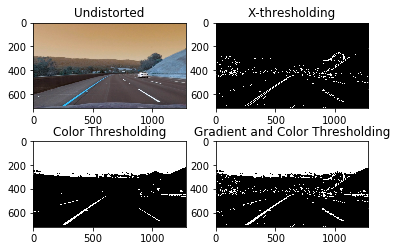

In [9]:
# On test image 3 first
image= 'test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)

 #Plots 
plt.figure(figsize=(10,10))
fig = plt.figure()
a=fig.add_subplot(2,2,1)
plt.imshow(undist)
a.set_title('Undistorted')

a=fig.add_subplot(2,2,2)
plt.imshow(sxbinary, cmap = 'Greys_r')
a.set_title('X-thresholding')

a=fig.add_subplot(2,2,3)
plt.imshow(s_binary, cmap = 'Greys_r')
a.set_title('Color Thresholding')

a=fig.add_subplot(2,2,4)
plt.imshow(combined_binary1, cmap = 'Greys_r')
a.set_title('Gradient and Color Thresholding')

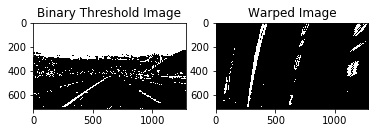

In [10]:
# On test image 3 first
image= 'test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)

 #Plots 
plt.figure(figsize=(10,10))
fig = plt.figure()
a=fig.add_subplot(121)
plt.imshow(combined_binary1, cmap = 'Greys_r')
a.set_title('Binary Threshold Image')

a=fig.add_subplot(122)
plt.imshow(warped_im, cmap = 'Greys_r')
a.set_title('Warped Image')

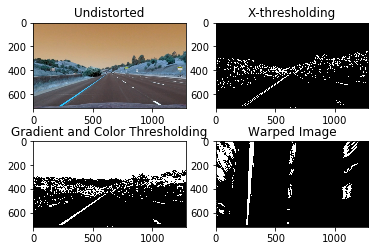

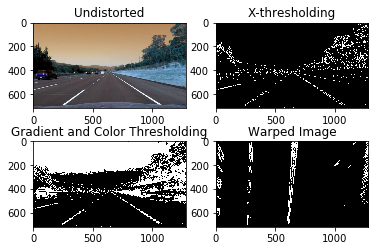

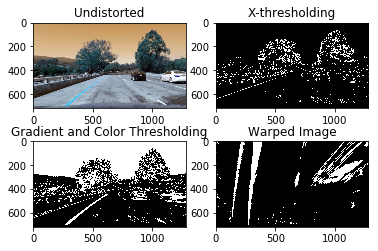

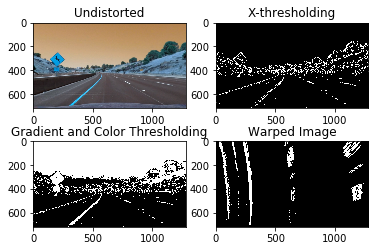

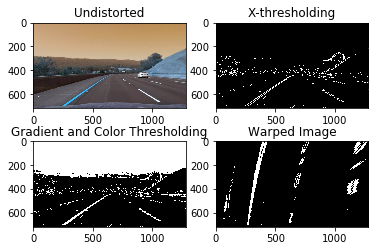

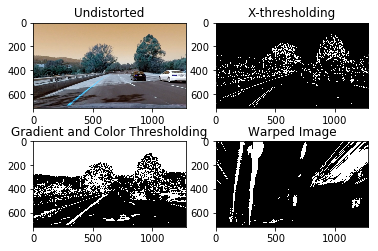

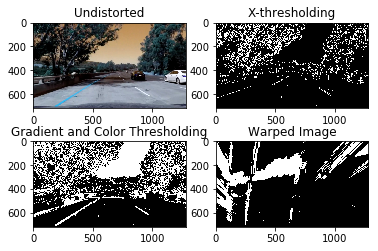

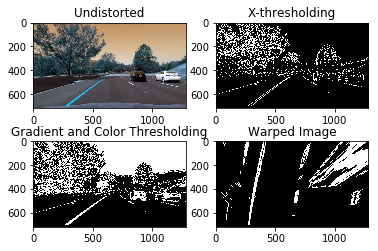

In [11]:
#  Test on test images and then save them to the test_images directory.
import glob
new_path = os.path.join("test_images/","*.jpg")
for infile in glob.glob(new_path):
    image = infile
    orig_image = cv2.imread(image)
    # Call lane_detector
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)
    
    # Save undist image
    outfile = create_pathname(infile, "_undist.jpg")
    cv2.imwrite(outfile, undist)
    
    #Save gradient thresholding
    sxbinary_disp = sxbinary*255
    outfile = create_pathname(infile, "_sxbinary.jpg")
    cv2.imwrite(outfile, sxbinary_disp)
    
    # Save color thresholding
    s_binary_disp = s_binary*255
    outfile = create_pathname(infile, "_sbinary.jpg")  
    cv2.imwrite(outfile, s_binary_disp)

    # Save gradient and color thresholding
    combined_binary1_disp = combined_binary1*255
    outfile = create_pathname(infile, "_combined_binary1.jpg")  
    cv2.imwrite(outfile, combined_binary1_disp)
    
    # Save gradient thresholding
    warped_im_disp = warped_im*255
    outfile = create_pathname(infile, "_warped.jpg")  
    cv2.imwrite(outfile, warped_im_disp)
    
    #Plots 
    plt.figure(figsize=(10,10))
    fig = plt.figure()
    a=fig.add_subplot(2,2,1)
    plt.imshow(undist)
    a.set_title('Undistorted')

    a=fig.add_subplot(2,2,2)
    plt.imshow(sxbinary, cmap = 'Greys_r')
    a.set_title('X-thresholding')

    a=fig.add_subplot(2,2,3)
    plt.imshow(combined_binary1, cmap = 'Greys_r')
    a.set_title('Gradient and Color Thresholding')

    a=fig.add_subplot(2,2,4)
    plt.imshow(warped_im, cmap = 'Greys_r')
    a.set_title('Warped Image')

In [12]:
# Functions for drawing lines 
def fit_lines(img, plot = True):

    binary_warped = img.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #Make this more robust
    midpoint = np.int(histogram.shape[0]/4) # lanes aren't always centered in the image
    leftx_base = np.argmax(histogram[150:midpoint]) + 150 #Left lane shouldn't be searched from zero
    rightx_base = np.argmax(histogram[midpoint: midpoint+500]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 70
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
       # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if plot == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()

        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit, right_fit, out_img

In [13]:
def fit_continuous(left_fit, right_fit, binary_warped, plot = True):
    #Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 50
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    if len(leftx) == 0:
        left_fit_new =[]
    else:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    
    
    if len(rightx) == 0:
        right_fit_new =[]
    else:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return left_fit_new, right_fit_new

In [14]:
#Calculate Curvature
def curvature(left_fit, right_fit, binary_warped, print_data = True):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    if print_data == True:
    #Now our radius of curvature is in meters
        print(left_curverad, 'm', right_curverad, 'm', center, 'm')

    return left_curverad, right_curverad, center

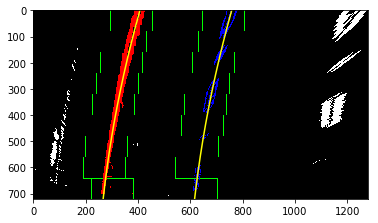

In [15]:
# On test image 3 first
image= 'test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)
left_fit, right_fit, out_img = fit_lines(warped_im)

15096.4959571 m 3508.83556757 m -0.863239180725 m
6129.84439486 m 7335.57205594 m -0.865418581489 m
2150.516576 m 3921.70628174 m -0.47987445325 m
874.517527801 m 684.068816846 m -1.17251740307 m
1372.74145512 m 1440.01645913 m -0.301476492904 m
3277.26277444 m 716.201314336 m -0.468729716855 m
262.434084006 m 2873.82354548 m -0.661983443822 m
2500.10747349 m 2500.10747349 m -1.21420289861 m


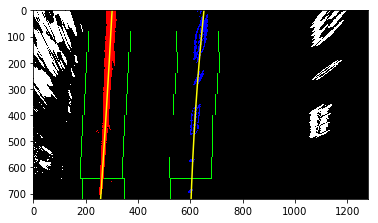

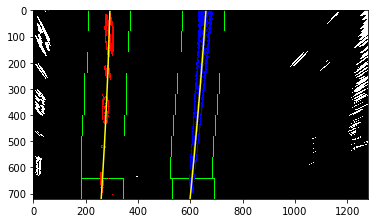

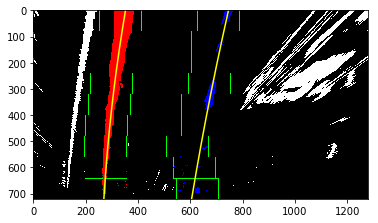

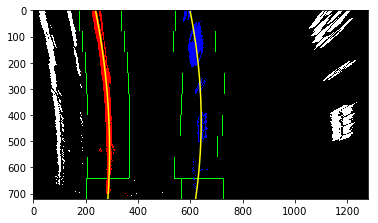

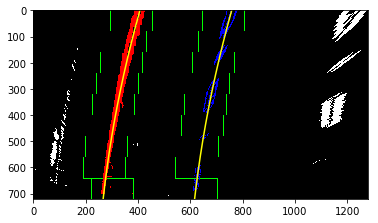

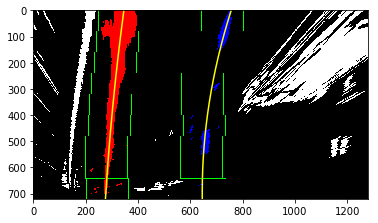

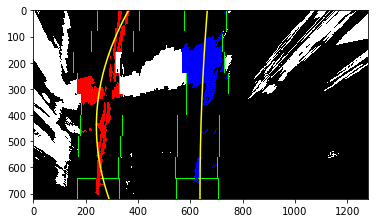

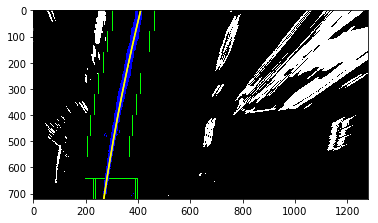

In [16]:
import glob
new_path = os.path.join("test_images/","*.jpg")
for infile in glob.glob(new_path):

    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(infile)

    left_fit, right_fit, out_img = fit_lines(warped_im)
    
    # Save fitline image
    out_img_disp = out_img
    outfile = create_pathname(infile, "_fitline.jpg")  
    cv2.imwrite(outfile, out_img_disp)
    
    curvature(left_fit, right_fit, out_img)

In [17]:
def add_text_to_image(img, left_cur, right_cur, center):
    """
    Draws information about the center offset and the current lane curvature onto the given image.
    :param img:
    """
    cur = (left_cur + right_cur)/2.

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)

    left_or_right = "left" if center < 0 else "right"
    cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), font, 1,
                (255, 255, 255), 2)

In [18]:
def draw_lines(undist, warped,left_fit, right_fit, left_cur, right_cur, center, show_img = True ):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    if show_img == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(result)
    
    return result

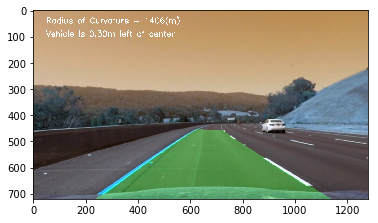

In [19]:
# On test image 3 first
image= 'test_images/test3.jpg'
orig_img = cv2.imread(image)
undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image)
left_fit, right_fit, out_img = fit_lines(warped_im, plot= False)
left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im, print_data = False)
result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = True)
    

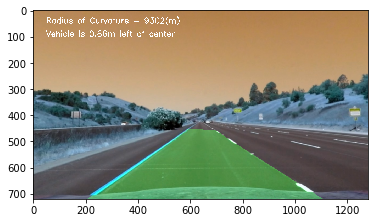

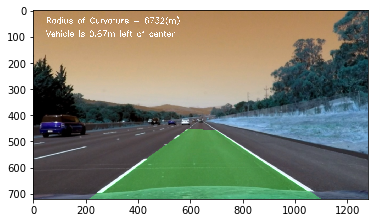

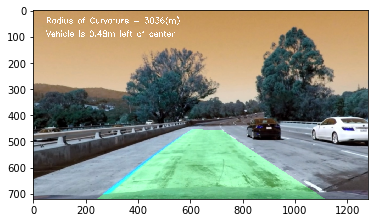

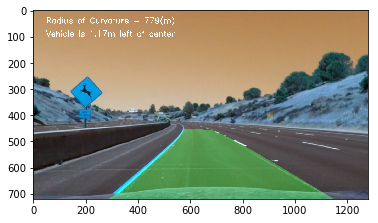

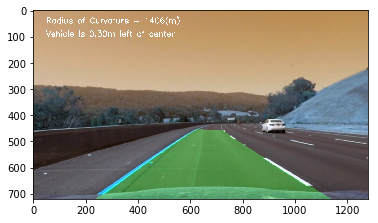

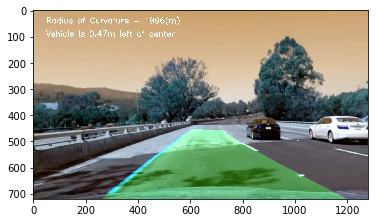

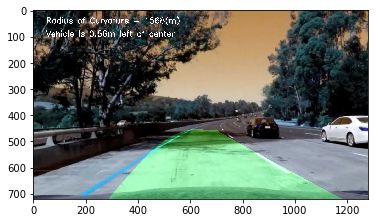

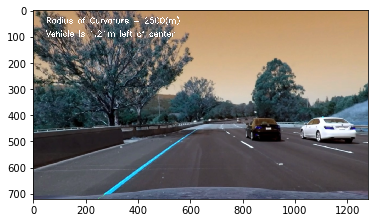

In [20]:
import glob
new_path = os.path.join("test_images/","*.jpg")
for infile in glob.glob(new_path):

    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(infile)

    left_fit, right_fit, out_img = fit_lines(warped_im, plot= False)
    left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im, print_data = False)
    result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = True)
    
    #Save result
    outfile = create_pathname(infile, "_unpersp.jpg")  
    cv2.imwrite(outfile, result)

In [21]:
def sanity_check(left_fit, right_fit):
    #Performs a sanity check on the lanes

    #1. Check if left and right fit returned a value
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False

    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines >= 150 and delta_lines <=430: #apprrox delta in pixels
            status = True
        else:
            status = False
        
        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
         # Calculate slope of left and right lanes at top of y (i.e. 720)
        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        delta_slope_top =  np.abs(L_1-R_1)
        
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            status = True
        else:
            status = False
            
    return status

In [22]:
# Pipeline for processing images 
def process_image(image):
    global counter
    global last_left 
    global last_right
    global left_fit
    global right_fit
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(image, video_mode = True)
    
    if counter ==0:
        left_fit, right_fit, out_img = fit_lines(warped_im, plot= False)
    else:
        left_fit, right_fit  = fit_continuous(left_fit, right_fit, warped_im, plot = False)
        
    # Do Sanity check
    status =sanity_check(left_fit, right_fit)
    
    #Decide if to use calculated points
    if status == True:        
        #Save as last reliable fit
        last_left, last_right = left_fit, right_fit        
        counter+=1
    else:        #Use the last realible fit
        left_fit, right_fit = last_left, last_right
        
    
    left_cur, right_cur, center = curvature(left_fit, right_fit, warped_im, print_data = False)
    
    result = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = False)
    
    return result

In [23]:
#Create video file pipeline
counter=0
output = 'test_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4").subclip(20,28)

out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print(counter)

[MoviePy] >>>> Building video test_video.mp4
[MoviePy] Writing video test_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:29<00:00,  4.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video.mp4 

Wall time: 4min 29s
1216


In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [25]:
#Create video file pipeline
counter=0
output2 = 'test_challenge_video.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
#clip2 = VideoFileClip("challenge_video.mp4").subclip(20,28)

clip2.save_frame("extra/frame.jpeg")
clip2.save_frame("extra/frame1.jpeg", t=1)
clip2.save_frame("extra/frame2.jpeg", t=2)
clip2.save_frame("extra/frame3.jpeg", t=3)
clip2.save_frame("extra/frame4.jpeg", t=4)
clip2.save_frame("extra/frame5.jpeg", t=5)
clip2.save_frame("extra/frame6.jpeg", t=6)
clip2.save_frame("extra/frame7.jpeg", t=7)
clip2.save_frame("extra/frame8.jpeg", t=8)

out_clip2 = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time out_clip2.write_videofile(output2, audio=False)
print(counter)

[MoviePy] >>>> Building video test_challenge_video.mp4
[MoviePy] Writing video test_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [01:39<00:00,  4.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_challenge_video.mp4 

Wall time: 1min 40s
80


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))

306.962707988 m 482.682877741 m -0.0936595115309 m
186.693003657 m 284.30624622 m 0.27315229363 m
409.029368415 m 300.223261715 m 0.0680865240128 m
715.912567478 m 185.860693402 m 0.316381679407 m
594.945282839 m 172.673073125 m 0.36811596293 m
1137.42191545 m 976.171342463 m -0.794276983131 m
462.224551207 m 445.13933888 m -0.588652826861 m
426.998182287 m 406.197064737 m 0.0327983342551 m
381.023398472 m 311.495796097 m -0.511735767761 m


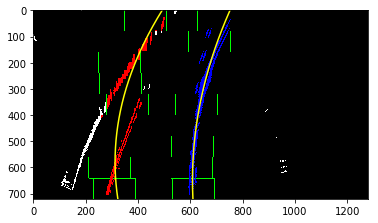

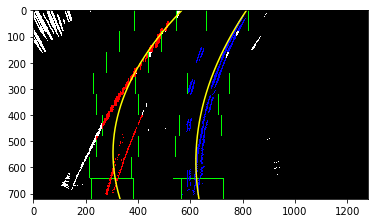

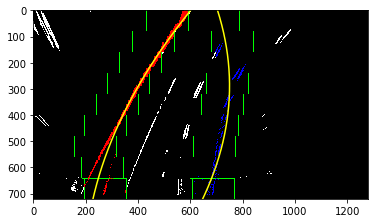

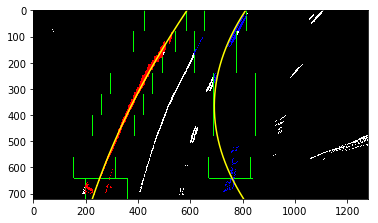

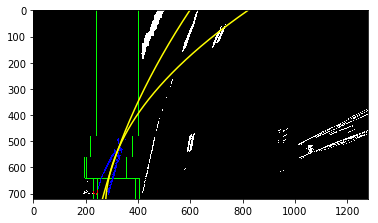

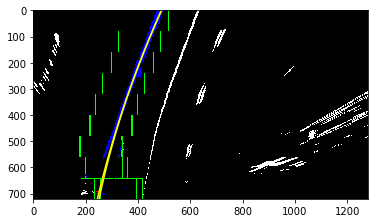

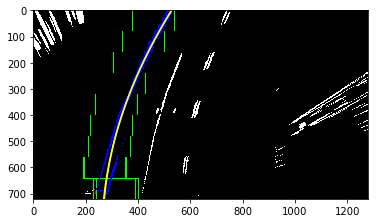

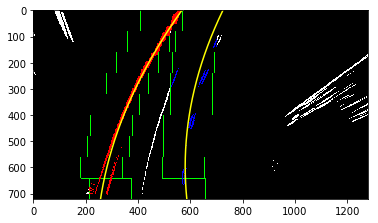

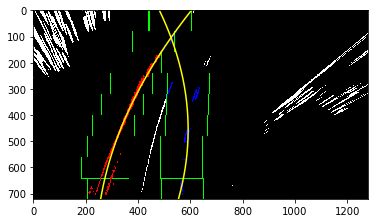

In [27]:
# Lets check whats is happening
import glob
new_path = os.path.join("extra/","*")
for infile in glob.glob(new_path):
    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(infile)

    left_fit, right_fit, out_img = fit_lines(warped_im)
    curvature(left_fit, right_fit, out_img)

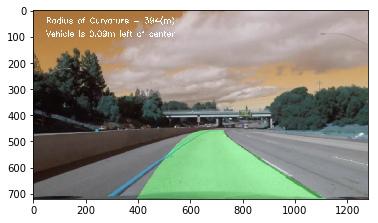

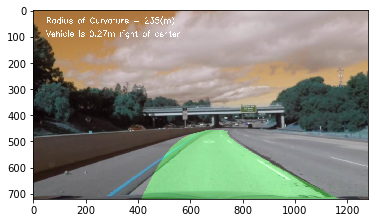

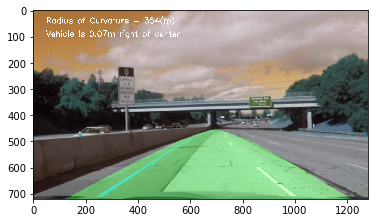

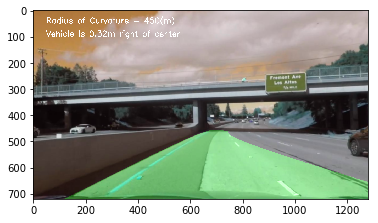

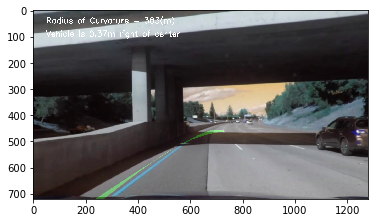

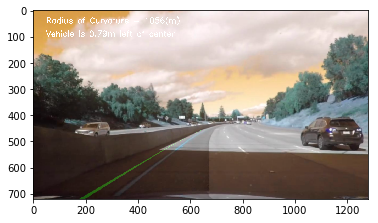

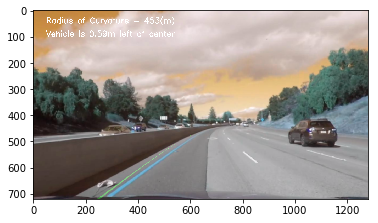

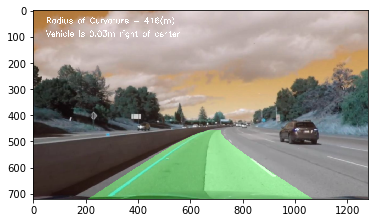

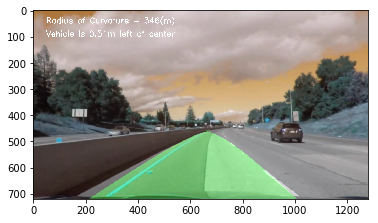

In [28]:
import glob
new_path = os.path.join("extra/","*")
for infile in glob.glob(new_path):

    undist, sxbinary, s_binary, combined_binary1, warped_im, Minv = lane_detector(infile)

    left_fit, right_fit, out_img = fit_lines(warped_im, plot= False)
    left_cur, right_cur, center = curvature(left_fit, right_fit, out_img, print_data = False)
    result  = draw_lines(undist, warped_im, left_fit, right_fit, left_cur, right_cur, center, show_img = True)